In [56]:
# full_scanvi_pipeline.py
import os
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, v_measure_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import scvi
from scvi.model import SCANVI
from datetime import datetime
from tqdm import tqdm

In [2]:
random_seed = 42
np.random.seed(random_seed)
sc.settings.seed = random_seed

# Step 0: Download the data

In [3]:
bulk_train_x = pd.read_csv("data/train_data/train_bulk.csv", index_col=0)
bulk_train_y = pd.read_csv("data/train_data/train_bulk_trueprops.csv", index_col=0)
bulk_test_x = pd.read_csv("data/test_data/test_bulk.csv", index_col=0)

In [25]:
sc_train = sc.read_h5ad("data/train_data/train_adata.h5ad")
sc_test = sc.read_h5ad("data/test_data/test_adata.h5ad")

In [5]:
print(sc_train.var.shape) # gene level
sc_train.var.head()

(7725, 6)


,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
Unnamed: 0,,,,,,
NOC2L,6735,False,6735,0.143681,87.143757,7527.0
HES4,8287,False,8287,0.330635,84.181190,17321.0
ISG15,19640,False,19640,0.871934,62.509783,45678.0
TNFRSF18,12021,False,12021,0.682345,77.053467,35746.0
TNFRSF4,7880,False,7880,0.484510,84.958100,25382.0


In [7]:
print(sc_train.obs.shape) # cell level
sc_train.obs.head()

(32374, 10)


,Sample,Patient,Tumor status,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,highLevelType,chemo
AAACCCAAGGAGACCT-1_1,s1,P1,Tumor,991,991,2156.0,131.0,6.076067,T,post
AAACCCAGTAGACAGC-1_1,s1,P1,Tumor,1063,1063,2485.0,84.0,3.380282,T,post
AAACCCAGTAGATCGG-1_1,s1,P1,Tumor,855,855,1993.0,87.0,4.365278,T,post
AAACCCAGTATCACCA-1_1,s1,P1,Tumor,1002,1002,2147.0,139.0,6.474150,B,post
AAACCCAGTTGGAGGT-1_1,s1,P1,Tumor,958,958,2438.0,108.0,4.429861,T,post


In [8]:
print(sc_train.X.shape) # expression of the cells by genes

(32374, 7725)


# Step 1: Perform SC clustering 

In [26]:
label_key = "highLevelType"
categorical_covariate_keys = ["Sample", "Tumor status", "Patient"]
batch_key = "Sample"

In [27]:
# sc.pp.filter_cells(sc_train, min_genes=200)
sc.pp.filter_genes(sc_train, min_cells=3)

sc_train.layers["counts"] = sc_train.X.copy()  # preserve counts
sc.pp.normalize_total(sc_train, target_sum=1e4)
sc.pp.log1p(sc_train)
sc_train.raw = sc_train

In [28]:
sc.pp.highly_variable_genes(
    sc_train,
    flavor="seurat_v3",
    n_top_genes=1200,
    subset=True,
    layer="counts",
    batch_key=batch_key,
)

In [33]:
scvi.model.SCVI.setup_anndata(
    sc_train,
    layer="counts",
    labels_key=label_key,
    categorical_covariate_keys=categorical_covariate_keys,
)

In [34]:
model = scvi.model.SCVI(sc_train)
model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

In [35]:
model.train(early_stopping=True, max_epochs=200, check_val_every_n_epoch=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 200/200: 100%|██████████| 200/200 [30:16<00:00,  8.17s/it, v_num=1, train_loss=486]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [30:16<00:00,  9.08s/it, v_num=1, train_loss=486]


In [36]:
tstamp = datetime.now().strftime("%Y%m%d-%H%M%S")
model_filename = f"data/model/{tstamp}_scvi_model"
model.save(model_filename)

In [ ]:
Z_train = model.get_latent_representation()

# Attach latent to original objects (so downstream Scanpy neighbors/leiden work)
sc_train.obsm["X_scANVI"] = Z_train

Without batch correction

In [ ]:
sc.tl.pca(sc_train)

In [50]:
sc.pp.neighbors(sc_train, n_pcs=30, n_neighbors=20, use_rep="X_pca")
sc.tl.umap(sc_train, min_dist=0.3)

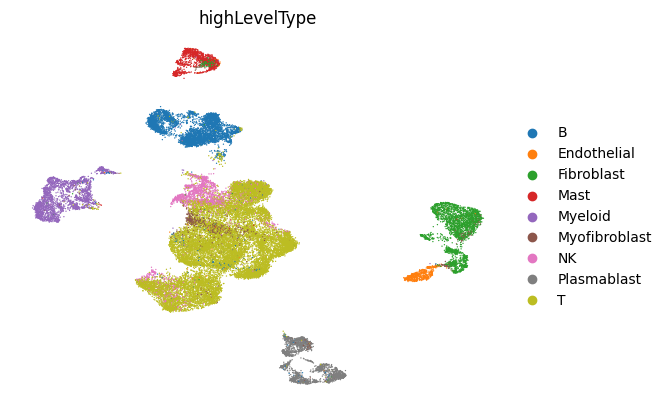

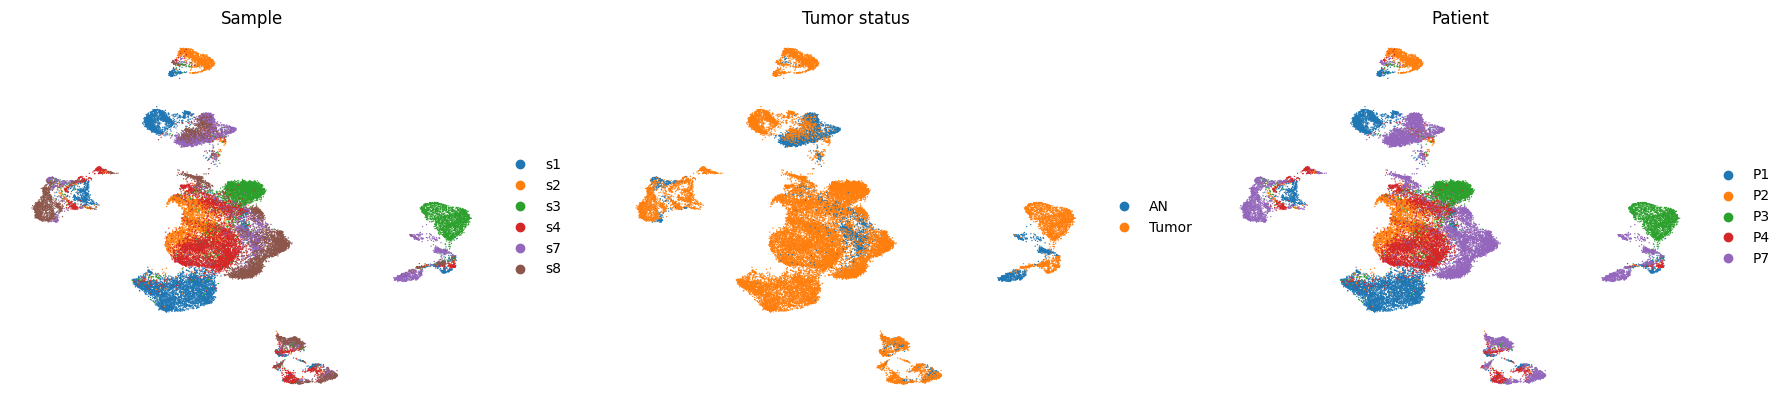

In [49]:
sc.pl.umap(
    sc_train,
    color=[label_key],
    frameon=False,
)

sc.pl.umap(
    sc_train,
    color=categorical_covariate_keys,
    frameon=False,
    ncols=len(categorical_covariate_keys),
)

In [51]:
sc.pp.neighbors(sc_train, use_rep="X_scANVI", n_neighbors=20)
sc.tl.umap(sc_train, min_dist=0.3)

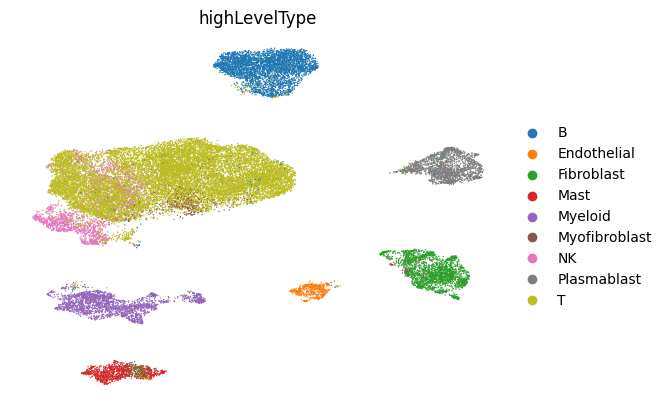

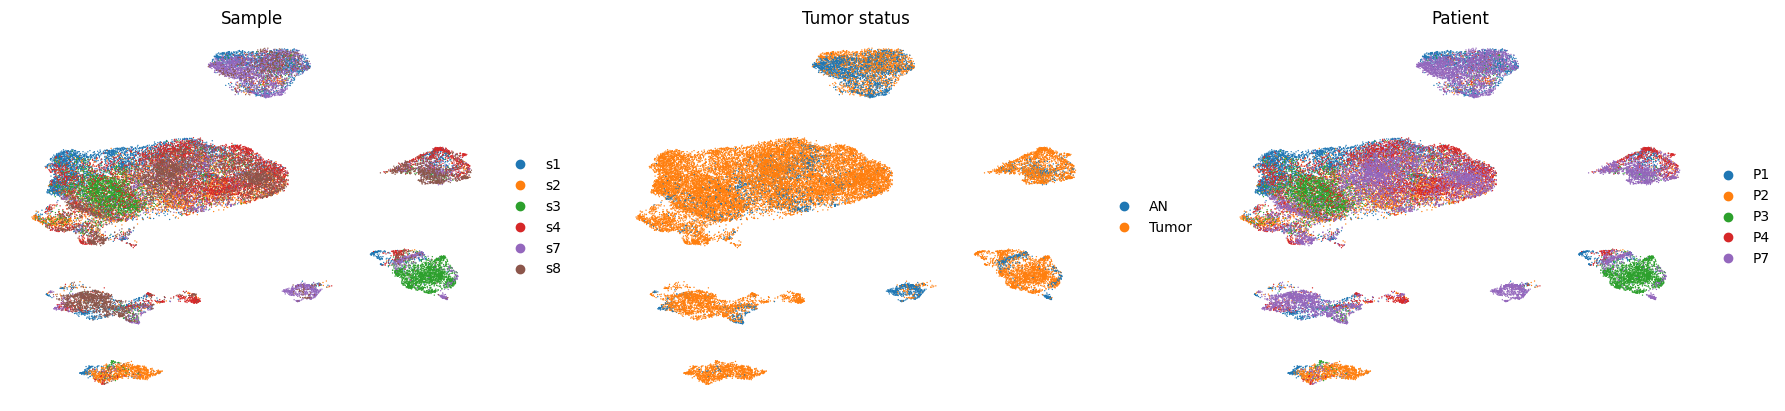

In [52]:
sc.pl.umap(
    sc_train,
    color=[label_key],
    frameon=False,
)

sc.pl.umap(
    sc_train,
    color=categorical_covariate_keys,
    frameon=False,
    ncols=len(categorical_covariate_keys),
)

In [53]:
true_labels = sc_train.obs[label_key].to_numpy()
sc.tl.leiden(sc_train, resolution=0.5, key_added="leiden_scVI")
pred_labels = sc_train.obs["leiden_scVI"].to_numpy()
ari = adjusted_rand_score(true_labels, pred_labels)
vmeas = v_measure_score(true_labels, pred_labels)
print(f"SCVI Leiden Clustering: ARI={ari:.4f}, V-measure={vmeas:.4f}, mean of the two={((ari+vmeas)/2):.4f}")


/tmp/ipykernel_850228/817747874.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(sc_train, resolution=0.5, key_added="leiden_scVI")


SCVI Leiden Clustering: ARI=0.3734, V-measure=0.6795, mean of the two=0.5264


In [58]:
# resolution search helper
def search_best_resolution(adata, true_label_key="highLevelType", nsteps=30, low=0.2, high=1.5):
    true_labels = adata.obs[true_label_key].values
    best_score = -1.0
    best_res = None
    for r in tqdm(np.linspace(low, high, nsteps)):
        tmp = adata.copy()
        sc.tl.leiden(tmp, resolution=float(r), key_added="tmp_cluster")
        pred = tmp.obs["tmp_cluster"].astype(str).values
        ari = adjusted_rand_score(true_labels, pred)
        v = v_measure_score(true_labels, pred)
        score = (ari + v) / 2
        if score > best_score:
            best_score = score
            best_res = float(r)
            print(f"New best resolution: {best_res} with score {best_score}")
    return best_res, best_score

best_res, best_score = search_best_resolution(sc_train, true_label_key="highLevelType", nsteps=30, low=0.01, high=.4)
print("Best resolution chosen (train):", best_res, "score:", best_score)

  3%|▎         | 1/30 [00:17<08:19, 17.23s/it]

New best resolution: 0.01 with score 0.6048557551552908


  7%|▋         | 2/30 [00:31<07:08, 15.29s/it]

New best resolution: 0.023448275862068966 with score 0.7931025014089681


 10%|█         | 3/30 [00:45<06:43, 14.93s/it]

New best resolution: 0.03689655172413793 with score 0.7934278758691524


 13%|█▎        | 4/30 [01:05<07:14, 16.72s/it]

New best resolution: 0.0503448275862069 with score 0.8057574960391112


 17%|█▋        | 5/30 [01:32<08:36, 20.67s/it]

New best resolution: 0.06379310344827586 with score 0.8078684524568678


 40%|████      | 12/30 [04:31<07:31, 25.09s/it]

New best resolution: 0.15793103448275864 with score 0.8097120053679159


100%|██████████| 30/30 [15:41<00:00, 31.37s/it]

Best resolution chosen (train): 0.15793103448275864 score: 0.8097120053679159


In [ ]:
sc.tl.leiden(sc_train, resolution=best_res, key_added="cluster")

# Step 2: Deconvolve the data

# Step 2bis: Predict on the test data

In [ ]:
# Assign clusters for test via KNN in latent space
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(sc_train.obsm["X_scANVI"], sc_train.obs["cluster"])
sc_test.obs["cluster"] = knn.predict(sc_test.obsm["X_scANVI"])

In [ ]:
# Optionally save predicted labels (with cell barcodes in index)
df_test = sc_test.obs[["cluster"]].reset_index().rename(columns={"index": "cell_id"})

In [ ]:
results = sc_test.obs["cluster"]
results = results.reset_index()

In [ ]:
pd.DataFrame(results).to_csv("results/cluster_membership.csv")

# Step 3: Save the required files

In [ ]:
# pred_props should be a DataFrame containing the estimated cell type proportions for the patients in all_bulkified
# pred_props.columns = ['index','s5_0','s5_1',...,'s10_3','s10_4'] = np.append(["index"],all_bulkified.columns)
# pred_props['index'] = ['T', 'Endothelial', 'Fibroblast', 'Plasmablast', 'B', 'Myofibroblast',
#       'NK', 'Myeloid', 'Mast']

In [ ]:
results_path = pl.Path("results")

In [ ]:
# cluster_labels should be a DataFrame containing the cluster labels for each cell
# cluster_labels.columns = ["index", "cluster"]
# cluster_labels["index"] = test_adata.columns

In [ ]:
pred_props = pd.read_csv("results/pred_props.csv", index_col=0)
cluster_labels = pd.read_csv("results/cluster_membership.csv", index_col=0)

In [ ]:
import zipfile

archive_name = "Negri_Edoardo_Project2.zip" # TODO

with zipfile.ZipFile(results_path / archive_name, "x") as zf:
    with zf.open(f"pred_props.csv", "w") as buffer:
        pred_props.to_csv(buffer)
    with zf.open(f"cluster_membership.csv", "w") as buffer:
        cluster_labels.to_csv(buffer)
    zf.close()